In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve
from rep.estimators import TMVAClassifier

In [2]:
#/notebooks/data/samples_for_comparison
sample_train = pd.read_csv('./sample_train.csv', index_col=0)

In [3]:
sample_train.head()

,Unnamed: 0.1,VeloCharge,BremPIDe,CaloNeutralPrs,CaloNeutralSpd,InAccBrem,InAccSpd,CaloPrsE,InAccPrs,HcalPIDe,...,piplus_OWNPV_XERR,piplus_OWNPV_YERR,piplus_OWNPV_ZERR,piplus_OWNPV_CHI2,piplus_OWNPV_NDOF,piplus_IP_OWNPV,piplus_IPCHI2_OWNPV,nCandidate,totCandidates,EventInSequence
17,3621,0.966292,-999.000000,-999.000000,-999,0,1,91.606766,1,0.596899,...,0.0108,0.0110,0.0614,29.302820,63,0.370735,3.431297,16,24,123
20,6171,0.922285,-0.373552,18.650478,1,1,1,36.752415,1,0.434916,...,0.0100,0.0099,0.0478,34.887810,69,2.378136,1060.891897,44,110,200
25,6898,0.859551,-999.000000,-999.000000,-999,0,1,159.351883,1,-1.755049,...,0.0100,0.0102,0.0605,39.176743,81,0.250419,6.240686,44,85,222
41,11245,1.320225,-0.553589,38.946587,1,1,1,54.580078,1,-0.525884,...,0.0120,0.0115,0.0623,26.412615,69,0.236727,4.247322,1,147,346
49,14841,1.095506,0.512278,0.000000,0,1,1,18.376207,1,-0.525884,...,0.0089,0.0088,0.0531,58.569302,119,0.096516,0.617738,0,66,461


In [4]:
sample_train.shape

(120000, 108)

In [5]:
sample_test = pd.read_csv('./sample_test.csv', index_col=0)

In [6]:
sample_test.head()

,VeloCharge,BremPIDe,CaloNeutralPrs,CaloNeutralSpd,InAccBrem,InAccSpd,CaloPrsE,InAccPrs,HcalPIDe,CaloHcalE,...,piplus_OWNPV_XERR,piplus_OWNPV_YERR,piplus_OWNPV_ZERR,piplus_OWNPV_CHI2,piplus_OWNPV_NDOF,piplus_IP_OWNPV,piplus_IPCHI2_OWNPV,nCandidate,totCandidates,EventInSequence
7,0.875468,-0.553589,58.145611,1,1,1,2.468446,1,-1.039939,2567.119141,...,0.0159,0.0155,0.1656,12.375439,31,0.174139,0.578183,56,153,2
12,0.821629,-0.532890,2.194174,1,1,0,-999.000000,0,-999.000000,-999.000000,...,0.0388,0.0307,0.2592,1.458854,5,0.200062,2.540836,17,65,3
16,0.955056,0.004340,0.000000,0,1,1,0.000000,1,-0.702660,1030.278442,...,0.0104,0.0103,0.0551,35.194836,79,0.017167,0.241404,25,50,4
24,0.906902,-0.553589,61.436871,1,1,1,2.194174,1,-0.970176,1236.716797,...,0.0145,0.0143,0.0758,13.201492,33,0.015376,0.237936,36,80,7
37,0.916433,-0.532890,26.330088,1,1,0,-999.000000,0,-999.000000,-999.000000,...,0.0082,0.0080,0.0388,59.964390,119,0.116683,1.638441,3,32,10


In [7]:
np.unique(sample_train.MCParticleType.values)

array([-3312, -3222, -3112, -2212,  -521,  -321,  -211,   -13,   -11,
           0,    11,    13,   211,   321,   521,  2212,  3112,  3222,  3312])

# Processing

In [8]:
import pickle

In [9]:
def calculate_auc(pid_dict, model, modelname, features_dict, train, test, dump=True):
    
    plt.figure(figsize=(8, 8))
    
    for pname, pid in pid_dict.items():
        # Read data
        features = features_dict[pname]
        
        X_train = train[features].values
        X_test = test[features].values
        y_train = (np.abs(train.MCParticleType.values) == pid).astype('int32')
        y_test = (np.abs(test.MCParticleType.values) == pid).astype('int32')

        # Fit
        if dump:
            model.fit(X_train, y_train)
            with open('models/' + modelname + '_' + pname + '.pkl', 'wb') as f:
                pickle.dump(model, f)
        else:
            with open('models/' + modelname + '_' + pname + '.pkl', 'rb') as f:
                model = pickle.load(f)

        # Eval
        preds = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        fpr, tpr, _ = roc_curve(y_test, preds)
        
        print pname, score
        plt.plot(fpr, tpr, lw=1, label='%s = %0.5f' % (pname, score))
        
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(modelname)
    plt.legend(loc="lower right")
    plt.show()

# Results

In [10]:
pid_dict = {"Ghost": 0,
            "Electron": 11,
            "Muon": 13,
            "Pion": 211,
            "Kaon": 321,
            "Proton": 2212
}
#/notebooks/data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx
features_file = {"Ghost": './GlobalPID_Ghost_Long_ANN.txt',
                 "Electron": './GlobalPID_Electron_Long_ANN.txt',
                 "Muon": './GlobalPID_Muon_Long_ANN.txt',
                 "Pion": './GlobalPID_Pion_Long_ANN.txt',
                 "Kaon": './GlobalPID_Kaon_Long_ANN.txt',
                 "Proton": './GlobalPID_Proton_Long_ANN.txt'
}

features_dict = {}

for pname, f in features_file.items():
    feats = np.loadtxt(f, dtype='S', delimiter='\n', comments='!')
    features_dict[pname] = [feat for feat in feats[5:] if '#' not in feat]

In [19]:
model = TMVAClassifier(method='kBDT',
                       factory_options="V:!Silent:!Color:!DrawProgressBar",
                       H='false',
                       V='true',
                       NTrees=50,
                       VarTransform = "Norm",
                       BoostType = "AdaBoost",
                       PruneMethod = "CostComplexity",
                       PruneStrength = -1,
                       MaxDepth = 3,
                       PruningValFraction = 0.3)

Ghost 0.953758492295
Muon 0.97837889459
Pion 0.923110043725
Kaon 0.918718285891
Proton 0.910151387791
Electron 0.928406467073


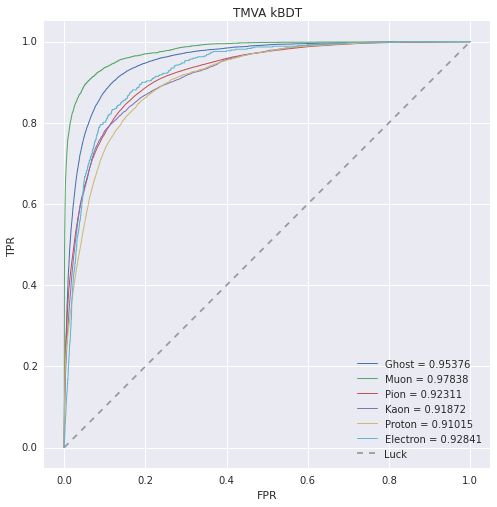

In [20]:
calculate_auc(pid_dict, model, 'TMVA kBDT', features_dict, sample_train, sample_test, dump=False)

In [11]:
model = TMVAClassifier(method='kMLP',
                       factory_options="V:!Silent:!Color:!DrawProgressBar",
                       H='true',
                       V='true',
                       EpochMonitoring='true',
                       UseRegulator='true',
                       ConvergenceImprove = "1e-16",
                       ConvergenceTests = "15",
                       VarTransform = "Norm",
                       NCycles = 50,
                       NeuronType = "sigmoid",
                       TrainingMethod = "BP",
                       EstimatorType = "CE")

Ghost 0.952366128763
Muon 0.969791968226
Pion 0.927040897145
Kaon 0.91522649549
Proton 0.895657049269
Electron 0.801738998433


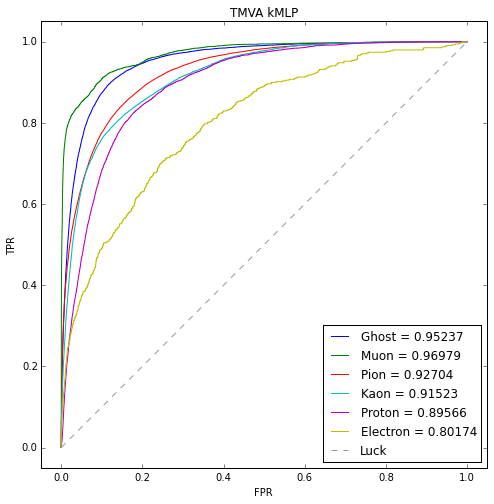

In [12]:
calculate_auc(pid_dict, model, 'TMVA kMLP', features_dict, sample_train, sample_test, dump=False)

In [21]:
plist = ['Electron', 'Pion', 'Kaon', 'Muon', 'Ghost', 'Proton']
mat_bdt = pd.DataFrame(0, index=plist, columns=plist)
for pone in plist:
    for ptwo in plist:
        if pone != ptwo:
            features = features_dict[pone]
            X = sample_test[(np.abs(sample_test.MCParticleType.values) == pid_dict[pone]) +
                            (np.abs(sample_test.MCParticleType.values) == pid_dict[ptwo])][features].values
            y = (np.abs(sample_test[(np.abs(sample_test.MCParticleType.values) == pid_dict[pone]) +
                             (np.abs(sample_test.MCParticleType.values) == pid_dict[ptwo])].MCParticleType.values) == pid_dict[pone]).astype('int')
            with open('models/TMVA kBDT_' + pone + '.pkl', 'rb') as f:
                model = pickle.load(f)
            preds = model.predict_proba(X)[:, 1]
            mat_bdt.loc[pone, ptwo] = roc_auc_score(y, preds)

In [22]:
mat_bdt

,Electron,Pion,Kaon,Muon,Ghost,Proton
Electron,0.000000,0.945801,0.923521,0.914866,0.865125,0.916700
Pion,0.831083,0.000000,0.931808,0.896631,0.926853,0.925286
Kaon,0.841422,0.942150,0.000000,0.937114,0.938094,0.646479
Muon,0.975309,0.977881,0.982346,0.000000,0.975600,0.983167
Ghost,0.854271,0.953835,0.956127,0.965766,0.000000,0.950912
Proton,0.834293,0.943848,0.669529,0.948223,0.930154,0.000000


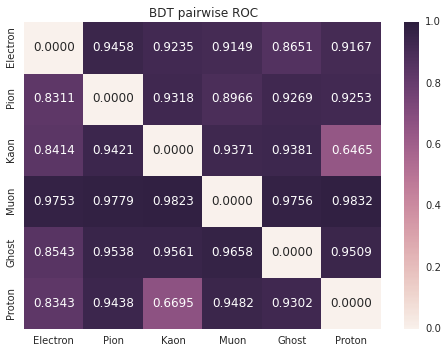

In [23]:
import seaborn as sns; sns.set()
ax = plt.axes()
sns.heatmap(mat_bdt, vmin=0., vmax=1., annot=True, fmt='.4f', ax=ax)

ax.set_title('BDT pairwise ROC')
plt.show()

In [13]:
plist = ['Electron', 'Pion', 'Kaon', 'Muon', 'Ghost', 'Proton']
mat_mlp = pd.DataFrame(0, index=plist, columns=plist)
for pone in plist:
    for ptwo in plist:
        if pone != ptwo:
            features = features_dict[pone]
            X = sample_test[(sample_test.MCParticleType.values == pid_dict[pone]) +
                            (sample_test.MCParticleType.values == pid_dict[ptwo])][features].values
            y = (sample_test[(sample_test.MCParticleType.values == pid_dict[pone]) +
                             (sample_test.MCParticleType.values == pid_dict[ptwo])].MCParticleType.values == pid_dict[pone]).astype('int')
            with open('models/TMVA kMLP_' + pone + '.pkl', 'rb') as f:
                model = pickle.load(f)
            preds = model.predict_proba(X)[:, 1]
            mat_mlp.loc[pone, ptwo] = roc_auc_score(y, preds)

In [14]:
mat_mlp

,Electron,Pion,Kaon,Muon,Ghost,Proton
Electron,0.000000,0.794178,0.820549,0.902611,0.689685,0.821296
Pion,0.799282,0.000000,0.914209,0.953353,0.937748,0.914528
Kaon,0.789977,0.940242,0.000000,0.936936,0.935207,0.650112
Muon,0.968473,0.969016,0.972633,0.000000,0.965812,0.975086
Ghost,0.821525,0.951632,0.957138,0.964871,0.000000,0.950580
Proton,0.829467,0.939154,0.557509,0.958669,0.919774,0.000000


/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


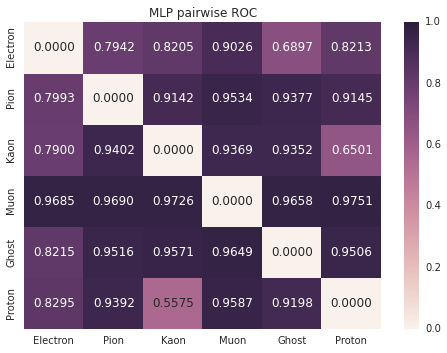

In [16]:
import seaborn as sns; sns.set()
ax = plt.axes()
sns.heatmap(mat_mlp, vmin=0., vmax=1., annot=True, fmt='.4f', ax=ax)

ax.set_title('MLP pairwise ROC')
plt.show()

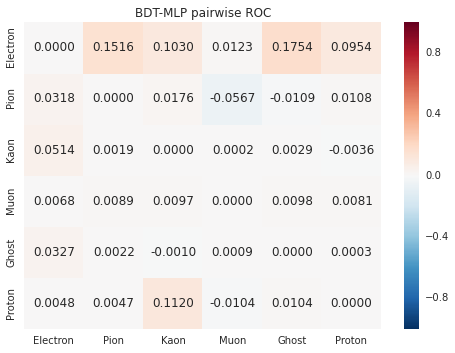

In [24]:
ax = plt.axes()
sns.heatmap(mat_bdt - mat_mlp, vmin=-1., vmax=1., annot=True, fmt='.4f', ax=ax)

ax.set_title('BDT-MLP pairwise ROC')
plt.show()

In [17]:
for p in pid_dict:
    with open('models/TMVA kMLP_' + p + '.pkl', 'rb') as f:
        model = pickle.load(f)
    preds = model.predict_proba(sample_test[features_dict[p]].values)
    print p
    print preds[:10, :]

Ghost
[[ 0.43822611  0.56177389]
 [ 0.44613152  0.55386848]
 [ 0.3611995   0.6388005 ]
 [ 0.49565296  0.50434704]
 [ 0.30297177  0.69702823]
 [ 0.4883218   0.5116782 ]
 [ 0.49531155  0.50468845]
 [ 0.16762502  0.83237498]
 [ 0.21857934  0.78142066]
 [ 0.48264937  0.51735063]]
Muon
[[ 0.45471478  0.54528522]
 [ 0.36916302  0.63083698]
 [ 0.44995854  0.55004146]
 [ 0.46182652  0.53817348]
 [ 0.21202588  0.78797412]
 [ 0.25334091  0.74665909]
 [ 0.4799131   0.5200869 ]
 [ 0.15957785  0.84042215]
 [ 0.38942083  0.61057917]
 [ 0.49870233  0.50129767]]
Pion
[[ 0.18231598  0.81768402]
 [ 0.16150767  0.83849233]
 [ 0.00699304  0.99300696]
 [ 0.00673039  0.99326961]
 [ 0.34944924  0.65055076]
 [ 0.0547273   0.9452727 ]
 [ 0.01013389  0.98986611]
 [ 0.35015658  0.64984342]
 [ 0.26931037  0.73068963]
 [ 0.2298468   0.7701532 ]]
Kaon
[[ 0.34013356  0.65986644]
 [ 0.33622057  0.66377943]
 [ 0.49975811  0.50024189]
 [ 0.49833007  0.50166993]
 [ 0.40033734  0.59966266]
 [ 0.41448717  0.58551283]
 [ 0

In [18]:
for p in pid_dict:
    with open('models/TMVA kBDT_' + p + '.pkl', 'rb') as f:
        model = pickle.load(f)
    preds = model.predict_proba(sample_test[features_dict[p]].values)
    print p
    print preds[:10, :]

Ghost
[[ 0.70479058  0.29520942]
 [ 0.65433362  0.34566638]
 [ 0.47004925  0.52995075]
 [ 0.85255483  0.14744517]
 [ 0.41375226  0.58624774]
 [ 0.85369166  0.14630834]
 [ 0.90943336  0.09056664]
 [ 0.44574277  0.55425723]
 [ 0.33360151  0.66639849]
 [ 0.7881202   0.2118798 ]]
Muon
[[ 0.73217153  0.26782847]
 [ 0.50854037  0.49145963]
 [ 0.75608761  0.24391239]
 [ 0.8045901   0.1954099 ]
 [ 0.40840454  0.59159546]
 [ 0.50222537  0.49777463]
 [ 0.84972035  0.15027965]
 [ 0.39611038  0.60388962]
 [ 0.46431126  0.53568874]
 [ 0.58471837  0.41528163]]
Pion
[[ 0.44392098  0.55607902]
 [ 0.36614643  0.63385357]
 [ 0.30371604  0.69628396]
 [ 0.13584493  0.86415507]
 [ 0.46716477  0.53283523]
 [ 0.35294915  0.64705085]
 [ 0.08233337  0.91766663]
 [ 0.48939356  0.51060644]
 [ 0.66669029  0.33330971]
 [ 0.35340784  0.64659216]]
Kaon
[[ 0.53069571  0.46930429]
 [ 0.60513134  0.39486866]
 [ 0.90374071  0.09625929]
 [ 0.87007599  0.12992401]
 [ 0.64400408  0.35599592]
 [ 0.56731797  0.43268203]
 [ 0